# 準備

In [34]:
import cv2
import glob
import re
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# データセットのルートパスを指定
root_path = './sample_data/ImageDetectionDataset/'

画像の確認

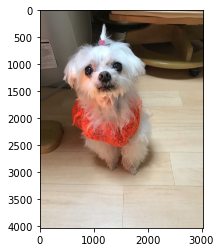

In [3]:
plt.imshow(cv2.cvtColor(cv2.imread(root_path + 'JPEGImages/dog1.jpeg'), cv2.COLOR_BGR2RGB))

## フォルダ構成の確認

In [4]:
glob.glob(root_path+'*/')

['./sample_data/ImageDetectionDataset/ImageSets/',
 './sample_data/ImageDetectionDataset/Annotations/',
 './sample_data/ImageDetectionDataset/JPEGImages/']

アノテーション情報が格納されている

In [5]:
sorted(glob.glob(root_path+'Annotations/*'), key=lambda x: int(re.sub('\D', '', x)))

['./sample_data/ImageDetectionDataset/Annotations/dog1.xml',
 './sample_data/ImageDetectionDataset/Annotations/dog2.xml',
 './sample_data/ImageDetectionDataset/Annotations/dog3.xml',
 './sample_data/ImageDetectionDataset/Annotations/dog4.xml']

画像データが格納されている

In [6]:
sorted(glob.glob(root_path+'JPEGImages/*'), key=lambda x: int(re.sub('\D', '', x)))

['./sample_data/ImageDetectionDataset/JPEGImages/dog1.jpeg',
 './sample_data/ImageDetectionDataset/JPEGImages/dog2.jpeg',
 './sample_data/ImageDetectionDataset/JPEGImages/dog3.jpeg',
 './sample_data/ImageDetectionDataset/JPEGImages/dog4.jpeg']

学習データと検証データの割当が記入されているtxtデータが格納されている

In [7]:
glob.glob(root_path+'ImageSets/Main/*')

['./sample_data/ImageDetectionDataset/ImageSets/Main/train.txt',
 './sample_data/ImageDetectionDataset/ImageSets/Main/val.txt']

# データパスリストの作成

In [8]:
def make_data_path_list(root_path, train_val, img_ext='jpg'):
    """
    Parameters
    ----------
    root_path : str
        データセットの親パス
    train_val : str
        'train' or 'val'
    img_ext : str
        画像データの拡張子
        
    Returns
    -------
    img_path_list : list of str
        画像データのパスリスト
        ['path/img1.jpg', 'path/img2.jpg']
    anno_path_list : list of str
        アノテーションデータのパスリスト
        ['path/img1.xml', 'path/img2.xml']
    """
    # 学習データの画像ファイルとアノテーションファイルへのパスリストを作成
    img_path_list = []
    anno_path_list = []

    id_names = root_path + 'ImageSets/Main/' + train_val + '.txt'

    for line in open(id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = root_path + 'JPEGImages/' + file_id + '.' + img_ext
        anno_path = root_path + 'Annotations/' + file_id + '.xml'
        img_path_list.append(img_path)
        anno_path_list.append(anno_path)

    return img_path_list, anno_path_list

In [9]:
make_data_path_list(root_path, 'train', img_ext='jpeg')

(['./sample_data/ImageDetectionDataset/JPEGImages/dog1.jpeg',
  './sample_data/ImageDetectionDataset/JPEGImages/dog3.jpeg'],
 ['./sample_data/ImageDetectionDataset/Annotations/dog1.xml',
  './sample_data/ImageDetectionDataset/Annotations/dog3.xml'])

# xmlファイルの情報を抽出する

In [10]:
class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        データセットで登場するクラス名を格納したリスト
    """

    # 矩形のクラスリストを入力する
    def __init__(self, classes):
        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):
            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報

            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # damagedatasetは原点が(1,1)なので1を引き算して（0, 0）
                cur_pixel = int(bbox.find(pt).text) - 1

                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # retに[xmin, ymin, xmax, ymax, label_ind]を追加
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_idx], ... ]

In [11]:
# データセットのクラスリスト
classes = ['dog', 'cat']

# インスタンスの作成
transform_anno = Anno_xml2list(classes)

# パスリストの作成
train_img_path_list, train_anno_path_list = make_data_path_list(root_path, 'train', img_ext='jpeg')

# 画像の読み込み
img = cv2.imread(train_img_path_list[0])  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
anno_info = transform_anno(train_anno_path_list[0], width, height)
anno_info

array([[0.13690476, 0.06374008, 0.68253968, 0.76364087, 0.        ]])

動作確認

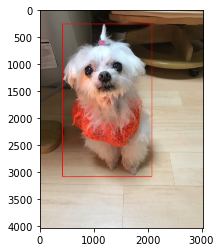

In [12]:
for anno in anno_info:
    # 規格化を元に戻す
    xmin, ymin, xmax, ymax = anno[:4]
    xmin *= width
    xmax *= width
    ymin *= height
    ymax *= height
    
    cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 10)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# transformの作成

In [13]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels

In [14]:
class ConvertFromInts:
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels

In [15]:
class Resize:
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size, self.size))
        return image, boxes, labels

In [16]:
class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels

In [2]:
# データオーグメンテーション用の前処理クラス
from image_detection import ConvertFromInts
from image_detection import ToAbsoluteCoords
from image_detection import PhotometricDistort
from image_detection import Expand
from image_detection import RandomSampleCrop
from image_detection import RandomMirror
from image_detection import ToPercentCoords
from image_detection import Resize
from image_detection import SubtractMeans
from image_detection import Compose

In [3]:
class DataTransform:
    """
    学習用と検証用の画像とアノテーションを前処理する
    data_transform : dict
        {'train' : 学習用の前処理クラス, 'val' : 検証用の前処理クラス}
    """
    def __init__(self, transform_list_train, transform_list_val):
        """
        Parameters
        ----------
        transform_list_train : list
            学習用の様々な前処理クラスを格納しているリスト
            [Resize(), ..., Augmentation()]
        transform_list_train : list
            検証用の様々な前処理クラスを格納しているリスト
            [Resize(), ...,]
        """
        self.data_transform = {"train": Compose(transform_list_train),
                               "val": Compose(transform_list_val)}

    def __call__(self, img, boxes, labels, phase):
        return self.data_transform[phase](img, boxes, labels)

動作の確認

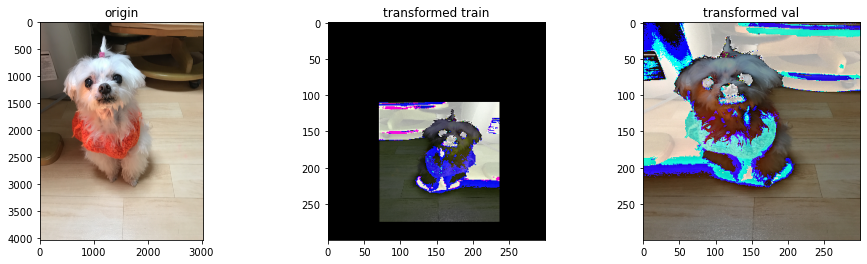

In [28]:
classes = ['dog', 'cat']
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. 画像読み込み
image_file_path = train_img_path_list[0]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(classes)
anno_list = transform_anno(train_anno_path_list[0], width, height)

# 3. 元画像の表示
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title('origin')

# 4. 前処理クラスの作成
input_size = 300  # 画像のinputサイズを300×300にする
color_mean = (100, 100, 100)  # 入力画像のBGR値平均
transform_list_train = [ConvertFromInts(),  # intをfloat32に変換
                        ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                        PhotometricDistort(),  # 画像の色調などをランダムに変化
                        Expand(color_mean),  # 画像のキャンバスを広げる
                        RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                        RandomMirror(),  # 画像を反転させる
                        ToPercentCoords(),  # アノテーションデータを0-1に規格化
                        Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                        SubtractMeans(color_mean)  # BGRの色の平均値を引き算
                       ]
transform_list_val = [ConvertFromInts(),  # intをfloat32に変換
                      Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                      SubtractMeans(color_mean)  # BGRの色の平均値を引き算
                     ]
transform = DataTransform(transform_list_train, transform_list_val)

# 5. transform後の画像の表示
np.random.seed(0)
torch.manual_seed(0)

img_transformed, boxes, labels = transform(img, anno_list[:, :4], anno_list[:, 4], 'train')
axes[1].imshow(cv2.cvtColor(img_transformed.astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[1].set_title('transformed train')

img_transformed, boxes, labels = transform(img, anno_list[:, :4], anno_list[:, 4], 'val')
axes[2].imshow(cv2.cvtColor(img_transformed.astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[2].set_title('transformed val')
plt.show()

# Datasetの作成

In [29]:
class ImageDetectionDataset(Dataset):
    """
    物体検出用のDatasetを作成するクラス
    PyTorchのDatasetクラスを継承

    Attributes
    ----------
    img_list : list
        画像のパスを格納したリスト
    anno_list : list
        アノテーションへのパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_path_list, anno_path_list, transform, transform_anno, phase):
        """
        Parameters
        ----------
        img_list : list
            画像のパスを格納したリスト
        anno_list : list
            アノテーションへのパスを格納したリスト
        transform : object
            前処理クラスのインスタンス
        transform_anno : object
            xmlのアノテーションをリストに変換するインスタンス
        phase : str
            'train' or 'val'
        """
        self.img_path_list = img_path_list
        self.anno_path_list = anno_path_list
        self.transform = transform
        self.transform_anno = transform_anno
        self.phase = phase

    def __len__(self):
        """
        データセット中の画像の枚数を返す
        """
        return len(self.img_path_list)

    def __getitem__(self, index):
        """
        前処理をした画像のテンソル形式のデータとアノテーションを出力
        
        Parameters
        ----------
        index : int
            データセットの何番目のデータを出力するか
        
        Returns
        -------
        img : tensor
            画像データ
            torch.Size([channls, h, w])
        gt : array
            バウンディングボックスの情報(ground truth)
            [xmin, ymin, xmax, ymax, class]
        """
        img, gt, h, w = self.pull_item(index)
        return img, gt

    def pull_item(self, index):
        """
        前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する
        
        Returns
        -------
        img : tensor
            画像データ
            torch.Size([channls, h, w])
        gt : array
            バウンディングボックスの情報(ground truth)
            [xmin, ymin, xmax, ymax, class]
        """

        # 画像読み込み
        image_file_path = self.img_path_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_path_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 前処理を実施
        img, boxes, labels = self.transform(img, anno_list[:, :4], anno_list[:, 4], self.phase)

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

動作確認

In [33]:
# クラス
classes = ['dog', 'cat']

# パスリストの作成
train_img_path_list, train_anno_path_list = make_data_path_list(root_path, 'train', img_ext='jpeg')
val_img_path_list, val_anno_path_list = make_data_path_list(root_path, 'val', img_ext='jpeg')

# 前処理クラスをまとめたリスト
input_size = 300  # 画像のinputサイズを300×300にする
color_mean = (100, 100, 100)  # 入力画像のBGR値平均
transform_list_train = [ConvertFromInts(),  # intをfloat32に変換
                        ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                        PhotometricDistort(),  # 画像の色調などをランダムに変化
                        Expand(color_mean),  # 画像のキャンバスを広げる
                        RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                        RandomMirror(),  # 画像を反転させる
                        ToPercentCoords(),  # アノテーションデータを0-1に規格化
                        Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                        SubtractMeans(color_mean)  # BGRの色の平均値を引き算
                       ]
transform_list_val = [ConvertFromInts(),  # intをfloat32に変換
                      Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                      SubtractMeans(color_mean)  # BGRの色の平均値を引き算
                     ]

# データセットの作成
train_dataset = ImageDetectionDataset(train_img_path_list, 
                                      train_anno_path_list,
                                      transform=DataTransform(transform_list_train, transform_list_val), 
                                      transform_anno=Anno_xml2list(classes),
                                      phase='train'
                                     )
val_dataset = ImageDetectionDataset(val_img_path_list, 
                                    val_anno_path_list, 
                                    transform=DataTransform(transform_list_train, transform_list_val), 
                                    transform_anno=Anno_xml2list(classes),
                                    phase='val'
                                   )

# データの取り出し例
val_dataset[0]

(tensor([[[ 10.2756,   7.0888,  13.7840,  ...,  -1.9340,  -0.2200,  -1.1652],
          [ 10.7288,   4.0264,  -0.2080,  ...,   4.0780,  15.5868,   8.6400],
          [  7.7940,   9.8820,   2.2400,  ...,   6.7000,  15.4820,  13.5320],
          ...,
          [105.3540, 109.5160, 111.1300,  ..., 123.3400, 123.6620, 125.7000],
          [106.1044, 111.0536, 114.9800,  ..., 126.1980, 124.1332, 121.0756],
          [108.2452, 110.9400, 115.7940,  ..., 122.9400, 123.0288, 121.5356]],
 
         [[-11.6200, -14.9112,  -8.2160,  ..., -24.1820, -24.2200, -24.1652],
          [-10.7312, -18.3336, -20.3720,  ..., -17.8400,  -9.8732, -14.6156],
          [-14.2060, -12.1180, -17.9600,  ..., -16.3000,  -7.5180,  -9.1680],
          ...,
          [107.3540, 109.5160, 111.1300,  ..., 125.3400, 125.6620, 127.7000],
          [108.9244, 111.4136, 114.9800,  ..., 128.1980, 126.0000, 123.0756],
          [109.2452, 111.9400, 116.7940,  ..., 124.8400, 124.0756, 123.6052]],
 
         [[-52.6548, -55.911

# DataLoaderの作成

In [38]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]：画像データ
        # アノテーションはnumpyの配列で入力されるためtensorに変換している
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]：アノテーションgt

    # imgsはミニバッチサイズのリストになっている
    # imgsの要素はtorch.Size([3, 300, 300])
      # 3：RGB
      #300：画像の縦サイズ
      #300：画像の横サイズ
    # imgsをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換する
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリスト
    # リストのサイズはミニバッチサイズ
    # リストtargetsの要素は [n, 5] となっている
    # nは画像ごとに異なり、画像内にある物体の数となる
    # 5：[xmin, ymin, xmax, ymax, class_index] 

    return imgs, targets

In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=od_collate_fn)

In [46]:
for (x, t) in train_dataloader:
    print("画像データミニバッチ")
    print(x)
    
    print("アノテーションデータミニバッチ")
    print(t)
    break

画像データミニバッチ
tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
         

# まとめ

In [4]:
from torch.utils.data import DataLoader

from image_detection import make_data_path_list
from image_detection import Anno_xml2list
from image_detection import ImageDetectionDataset
from image_detection import od_collate_fn

# データオーグメンテーション用の前処理クラス
from image_detection import ConvertFromInts
from image_detection import ToAbsoluteCoords
from image_detection import PhotometricDistort
from image_detection import Expand
from image_detection import RandomSampleCrop
from image_detection import RandomMirror
from image_detection import ToPercentCoords
from image_detection import Resize
from image_detection import SubtractMeans
from image_detection import DataTransform

In [5]:
# データセットのルートパスを指定
root_path = './sample_data/ImageDetectionDataset/'

In [6]:
# クラス
classes = ['dog', 'cat']

# パスリストの作成
train_img_path_list, train_anno_path_list = make_data_path_list(root_path, 'train', img_ext='jpeg')
val_img_path_list, val_anno_path_list = make_data_path_list(root_path, 'val', img_ext='jpeg')

In [7]:
# 前処理クラスをまとめたリスト
input_size = 300  # 画像のinputサイズを300×300にする
color_mean = (100, 100, 100)  # 入力画像のBGR値平均
transform_list_train = [ConvertFromInts(),  # intをfloat32に変換
                        ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                        PhotometricDistort(),  # 画像の色調などをランダムに変化
                        Expand(color_mean),  # 画像のキャンバスを広げる
                        RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                        RandomMirror(),  # 画像を反転させる
                        ToPercentCoords(),  # アノテーションデータを0-1に規格化
                        Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                        SubtractMeans(color_mean)  # BGRの色の平均値を引き算
                       ]
transform_list_val = [ConvertFromInts(),  # intをfloat32に変換
                      Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                      SubtractMeans(color_mean)  # BGRの色の平均値を引き算
                     ]

In [8]:
# データセットの作成
train_dataset = ImageDetectionDataset(train_img_path_list, 
                                      train_anno_path_list,
                                      transform=DataTransform(transform_list_train, transform_list_val), 
                                      transform_anno=Anno_xml2list(classes),
                                      phase='train'
                                     )
val_dataset = ImageDetectionDataset(val_img_path_list, 
                                    val_anno_path_list, 
                                    transform=DataTransform(transform_list_train, transform_list_val), 
                                    transform_anno=Anno_xml2list(classes),
                                    phase='val'
                                   )

# データローダーの作成
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=od_collate_fn)